# Progetto Data and Web Mining 2021
### Ferrari Simone, Trolese Giulio

## Introduzione
Il progetto di quest’anno si basa su una **competizione Kaggle**, in particolare la **TMDB Box Office Prediction**.  
Ci vengono forniti dati su oltre 3000 film del passato presi dal **The Movie Database** con lo scopo di predirre il loro incasso. 

## Fase preliminare
Come prima cosa, dobbiamo **preparare l'ambiente di lavoro**. 
In particolare, eseguiamo:
- Il caricamento delle librerie
- La lettura dei dati

Inoltre, di seguito sono raccolte tutte le funzioni di uso generale.

### Caricamento delle librerie

In [184]:
import pandas as pd    # Pandas
import numpy as np     # Numpy

from sklearn.model_selection import train_test_split    # Splitting dataframe in Train / Test
from sklearn.decomposition import PCA                   # Dimensionality reduction
from sklearn.preprocessing import MultiLabelBinarizer   # One Hot Encoding delle featuers
from sklearn.metrics import accuracy_score              # Calcolo dell'accuracy 
from sklearn import tree                                # Modelli con alberi
from sklearn.linear_model import LinearRegression       # Modello di regressione lineare
from sklearn.metrics import mean_squared_error          # Calcolo accuracy 
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt                         # Creare plot
import seaborn as sns                                   # Creare plot
from collections import Counter                         # Contare le frequenze
import json                                             
import ast                                              # Convertire stringa in dizionario
import scipy.stats

import warnings
warnings.filterwarnings('ignore')

### Funzioni utili utilizzate in seguito

In [2]:
# Colonne del dataframe che sono in formato stringa e devono essere convertite in dizionari
columnsToChange = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# Funzione che, preso un dataframe, lo maneggia e cambia le columnsToChange da stringhe a liste di dizionari
def stringToDictionary(dataFrame): 
    for column in columnsToChange:                                 # Per ogni colonna indicata in columnsToChange
        dataFrame[column] = dataFrame[column].apply(               # Modifica la colonna come segue 
            lambda x: {} if pd.isna(x) else ast.literal_eval(x))   # Dizionario vuoto se l'elemento è NaN, altrimenti converte la stringa
    return dataFrame                                               # Ritorna il dataframe modificato

In [3]:
# Funzione che, presa una lista, ritorna una nuova lista contenente solo l'elemento name di ogni elemento nella colonna selezionata
def convert(in_list):
    output = []                       # Crea una lista vuota
    for elem in in_list:              # Per ogni elemento nella colonna
        output.append(elem["name"])   # Inserisce, in ordine, solo il name degli elementi presenti nella colonna
    return output                     # Ritorna la nuova lista

In [4]:
# Funzione che preso un dataframe e una colonna, ritorna un dataset con il conteggio di elementi per ogni riga della colonna data
def elem_in_column_counter(dataset, column):
    tot_counter = []                                            # Lista vuota
    for elem in dataset[column]:                                # per ogni elemento nella colonna
        tot_counter.append(len(elem))                           # Inserisco nella lista il nuero di elementi contnenuti nell'elemento colonna (sono liste..)
     
    return pd.DataFrame(tot_counter, columns=[column+'_count'])    # ritorno il dataframe

In [5]:
# Funzione che, presa una lista, ritorna una nuova lista contenente il nome del direttore e il numero di membri della crew di ogni film
def convert_crew(in_list):
    output = []                                    # Crea una lista vuota
    i = 0                                          # contatore a 0
    flag = 1                                       # flag per un solo regista
    for elem in in_list:                           # Per ogni elemento nella colonna
        i += 1                                     # aumenta il contatore
        if flag and elem["job"] == 'Director':     # Se l'elemento rappresenta un regista e non ne ho ancora travato uno
            output.append(elem["name"])            # Inserisce, il nome del regista
            flag=0
            
    output.append(i)                      # Inserisce in coda il numero di componenti nella lista
    return output                         # Ritorna la nuova lista

In [6]:
# Funzione che prende i valori di una colonna e li ritorna in una lista
def values_to_list(column, dataset):
    values = []                       # Lista vuota
    for l in dataset[column]:         # Per ogni lista conenuta nella colonna
        for elem in l:                # Per ogni elemento nella lista 
            values.append(elem)       # Inserisce l'elemento nella lista di ritorno
    return values                     # Ritorna la lista

In [7]:
# Funzione che ritorna il numero di istanze vuote ([]) nella colonna selezionata
def empty_number(column):
    sum = 0                           # Inizializzo il totale a 0
    for i in df[column]:              # Per ogni elementi nella colonna
        if len(i)==0:                 # Se è vuoto
            sum+=1                    # Aumenta il contatore
    return sum                        # Ritorna il conteggio

In [8]:
# Funzione che ritorna gli indici degli elementi vuoti ([]) contenuti in una colonna
def find_empty_index(column):
    empty = []                                       # Lista vuota
    for index, elem in enumerate(df[column]):        # Per ogni indice ed elemento nella colonna
        if len(elem) == 0:                           # Se l'elemento ha lunghezza 0
            empty.append(index)                      # Significia che è vuota e aggiungo l'index alla lista
    return empty                                     # Ritorno la lista di indici

In [9]:
# Funzione che, preso un dataframe, preso una colonna e presa una percentuale di dati "da tenere", applica One Hot Encoding e riduce la dimensionalità in modo da manterene la proporzione specificata. 
def reduction(df, column):#, perc_keep):
    mlb = MultiLabelBinarizer()                                                 # Inizializzazione del mlb                                          
    df_conv = pd.DataFrame(mlb.fit_transform(df[column]),columns=column+" "+mlb.classes_, index=df.index)  # Si applica One Hot Encoding
    #pca = PCA(n_components = int(df_conv.shape[1]*perc_keep/100))               # Si inizializza PCA per la riduzione della dimensionalità
    #reduced = pca.fit_transform(df_conv)                                        # Si applica il PCA
    red_df = pd.DataFrame(df_conv)#reduced)                                              # Si trasforma il risultato in un Dataframe
    #red_df.rename(columns=lambda x: column+str(x), inplace=True)                # Si rinominano le colonne
    out = pd.concat([df,red_df], axis = "columns")                              # Si concatena il vecchio dataframe con le nuove colonne generate
    out.drop(column, axis='columns', inplace = True)                            # Si droppa la vecchia colonna utilizzata
    return out                                                                  # Si ritorna il dataframe

In [10]:
# Funzione che ritorna il numero di unità che costituiscono gli elementi di una colonna: es genres = Horror, Comedy, Action, ... in totale 20
def how_many(column, dataset):
    return len(list(Counter(values_to_list(column, dataset))))   # ritorna la lunghezza della lista generata dal counter

In [11]:
# Funzione che conta quante occorrenze significative sono presenti in column
def count_most_significative(dataset, column, CONST_LIST):
    tot_counter = []                              # Lista vuota
    for elem_list in dataset[column]:             # Per ogni lista della colonna
        counter = 0;                              # Conteggio a 0  
        for elem in elem_list:                    # Per ogni elemento della lista
            if(elem in CONST_LIST):               # Se è tra quelli signfificativi
                counter+=1                        # Aumento il contatore
        tot_counter.append(counter)               # Aggiungo il conteggio alla lista
    
    return pd.DataFrame(tot_counter, columns=[column+'_most_significative'])    # Converto la lista in dataframe

In [12]:
# Funzione che applica la mediana. 
# - datafram: dataframe a cui appilicare le operazioni
# - column: colonna a cui applicare la modifica
# - operation: criterio per decidere a cosa applicare la mediana
# - value: valore soglia
def apply_median(dataframe, column, operation, value):
    if operation == '<=':                                                            # operazione <=
        median = dataframe[column].median(skipna=True)                               # calcolo mediana
        dataframe[column]=dataframe[column].mask(dataframe[column]<=value, median)   # sostituzione dei valori sotto la soglia
    elif operation == '==':                                                          # operazione <=
        median = dataframe[column].median(skipna=True)                               # calcolo mediana
        dataframe[column]=dataframe[column].mask(dataframe[column]==value, median)   # sostituzione dei valori sotto la soglia
    else:
        print("Error: " + operation + " non valido, inserisci <= o ==")              # operazione non valida

In [13]:
# Funzione che rimuove tutte gli elementi della colonna column che hanno occorrenza inferiore a min_occurrence
def delete_useless_small_value(dataframe, min_occurrence, column):
    counter = Counter(values_to_list(column, dataframe)).most_common() # Conta le occorrenze di ogni elemento
    result = []                                          # Lista delle collection "buone"
    for elem,number in counter:                          # per ogni elemento e numero di occorrenza
        if number >= min_occurrence:                     # se il numero di occorrenze è maggiore alla soglia voluta
            result.append(elem)                          # si tiene l'elemento
    
    for i in range(0, len(dataframe)):                   # per len(dataframe) volte
        elem = dataframe[column][i]                      # salvo la lista contenuta in dataframe[column][i]
        temp = []                                        # lista di elementi buoni temporanea
        if len(elem):                                    # se non è vuota
            for elem_in_list in elem:                    # Per ogni elemento nella lista
                if elem_in_list in result:               # Se l'elemento è in result, e quindi è buono
                     temp.append(elem_in_list)           # Lo aggiungo alla lista temporanea
            elem.clear()                                 # Elimino tutta la vechcia lista
            elem.extend(temp)                            # Inserisco solo i valori buoni trovati.

In [14]:
# Funzione che rimuove tutte gli elementi della colonna column che hanno occorrenza superiore a max_occurrence
def delete_useless_big_value(dataframe, max_occurrence, column):
    counter = Counter(values_to_list(column, dataframe)).most_common() # Conta le occorrenze di ogni elemento
    result = []                                          # Lista delle collection "buone"
    for elem,number in counter:                          # per ogni elemento e numero di occorrenza
        if number <= max_occurrence:                     # se il numero di occorrenze è maggiore alla soglia voluta
            result.append(elem)                          # si tiene l'elemento
    
    for i in range(0, len(dataframe)):                   # per len(dataframe) volte
        elem = dataframe[column][i]                      # salvo la lista contenuta in dataframe[column][i]
        temp = []                                        # lista di elementi buoni temporanea
        if len(elem):                                    # se non è vuota
            for elem_in_list in elem:                    # Per ogni elemento nella lista
                if elem_in_list in result:               # Se l'elemento è in result, e quindi è buono
                     temp.append(elem_in_list)           # Lo aggiungo alla lista temporanea
            elem.clear()                                 # Elimino tutta la vechcia lista
            elem.extend(temp)                            # Inserisco solo i valori buoni trovati.

In [15]:
# Funzione che seleziona solo i top k elementi di ogni elemento della colonna column
def select_first_k(dataframe, column, k):    
    for i in range(0, len(dataframe)):                           # per ogni riga 
        elem = dataframe[column][i]                              # salvo la lista contenuta in dataframe[column][i]
        temp = []                                                # lista di elementi buoni temporanea
        if len(elem) > k:                                        # Se ci sono più di k elementi
            for j in range(0, k):                                # per k volte
                temp.append(elem[j])                             # inserisci il j-esimo elemento in temp
            elem.clear()                                         # Elimino tutta la vechcia lista
            elem.extend(temp)                                    # Inserisco solo i valori buoni trovati.

### Lettura dei dati

In [16]:
# lettura del file train.csv
df = pd.read_csv("train.csv")

In [17]:
# Conversione delle colonne di tipo String in colonne di tipo Lista di Dizionario
df = stringToDictionary(df)

## Prima analisi del dataframe

Di seguito andremo ad **analizzare nel suo insieme il dataframe**, valutando **quali features possono essere utili** per il nostro scopo e quali, invece, possono essere rimosse. 

In [18]:
pd.set_option('display.max_columns', None) # Visualizza tutte le colonne del dataframe
df.head() # Visualizzazione delle prime entry del dataframe

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


**Osservazioni**: 
- Il dataframe comprende 23 colonne (features), di cui alcune sembrano poco utili al nostro scopo... successivamente approfondiremo. 
- Alcune features sono dati strutturati, comprendendo più informazioni all'interno della stessa colonna.  
Esempi sono `belongs to collection`, `genres`, ...

In [19]:
df.info() # Visualizzazione delle info delle colonne

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  3000 non-null   object 
 2   budget                 3000 non-null   int64  
 3   genres                 3000 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   3000 non-null   object 
 12  production_countries   3000 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

**Osservazioni**: 
- Alcune features hanno valori nulli: sarà materia di successive indagini. 

In [20]:
df.describe(include='all') # Visualizzazione delle statistiche principali di tutte le colonne

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,3000,3.000000e+03,3000,946,3000,3000,3000,2992,3000.000000,2999,3000,3000,3000,2998.000000,3000,3000,2403,3000,3000,3000,3000,3.000000e+03
unique,NaN,423,NaN,873,941,3000,36,2975,2992,NaN,2999,2384,322,2398,NaN,402,2,2400,2969,2649,2976,2985,NaN
top,NaN,{},NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt2725962,en,Lolita,Aging outlaw Pike Bishop (William Holden) prep...,NaN,/viPjZ3JCOahcfNCcVhiPExusJoZ.jpg,{},"[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,King Kong,{},{},{},NaN
freq,NaN,2396,NaN,266,4,1,2575,2,1,NaN,1,156,1752,5,NaN,1817,2996,3,2,276,13,16,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


**Osservazioni**: 
- Alcuni valori sono sospetti, ad esempio: 
    - Il minimo `budget` è pari a 0... ma un film può avere budget 0? Poco probabile.
    - Il minimo di `runtime` è pari, nuovamente, a 0... anche in questo caso, è poco probabile, in quanto un film sicuramente dura più di 0 minuti!
    - Ha senso una `revenue` pari ad 1? Non troppo...
- Osserviamo che `status` ha solo due possibili valori
- Si osserva invece che `id` e `imdb_id` hanno valori univoci

## Manipolazione del dataframe

Dalle **analisi** eseguite ai punti **precedenti**, **abbiamo appreso** le seguenti informazioni:
- Abbiamo features che, molto probabilemnte, sono poco utili ai nosti scopi
- Abbiamo features strutturate che si potrebbero semplificare

Procediamo, quindi, **manipolando i dati in modo da renderli più maneggevoli e corretti**.

In [21]:
# Rinomina della colonna Keywords, per puri motivi di coerenza con uso di maiuscole. 
df.rename(columns={'Keywords': 'keywords'}, inplace=True) 

### Rimozione delle features poco utili

#### ID e IMDB_ID
Come detto, `id` e `imdb_id` hanno **valori univoci**, per cui possono essere rimossi in quanto non hanno rilevanza nella predizione. 

In [22]:
# Rimozione delle colonne id e imdb_id dal dataframe df
df.drop(['id'], axis='columns', inplace=True)

# NOTA: imdb_id verrà droppato solo a fine analisi, in quanto ci è utile per recuperare dati mancanti dei film

#### Titoli dei film
Gli `original_title` e `title`, nella maggior parte dei casi, sono **valori univoci** (`2975/3000 e 2969/3000`), mentre quei **pochi titoli duplicati** sono molto probabilmente **incorrelati** tra di loro.  
Possiamo quindi rimuoverli dal nostro dataframe.  

In [23]:
# Rimozione delle colonne original_title e title dal dataframe df
df.drop(labels=['original_title','title'], axis='columns', inplace=True)

#### Homepage, PosterPath e Status
Le `homepage` e i `poster_path` risultano essere features da cui è **difficile estrapolare informazioni utili**. Possiamo quindi rimuoverle. 

In [24]:
# Rimozione delle colonne homepage, poster_path e status dal dataframe df
df.drop(labels=['homepage','poster_path', 'status'], axis='columns', inplace=True)

#### Lingua originale
L'`original_language` la riteniamo **poco utile** ai fini di predirre la revenue, in quanto sono molto più d'interesse le lingue in cui un film è stato tradotto: contenute in `spoken_languages`

In [25]:
# Rimozione della colonna original_language dal dataframe df
df.drop(labels=['original_language'], axis='columns', inplace=True)

#### Overview e Tagline
Le features `overview` e `tagline` sono di tipo testuale e sono **complesse da analizzare**.  
Per ora le rimuoviamo, in quanto, per i nostri scopi, l'insieme delle `keywords` sicuramente ci può essere di **sufficiente** aiuto. 

In [26]:
# Rimozione delle colonne overview e tagline dal dataframe df
df.drop(labels=['overview', 'tagline'], axis='columns', inplace=True)

#### Rivalutare il dataframe
Arrivati a questo punto, abbiamo rimosso alcune features e **il nostro dataframe appare nel seguente modo:**

In [27]:
pd.set_option('display.max_columns', None) # Visualizza tutte le colonne del dataframe
df.head()

,belongs_to_collection,budget,genres,imdb_id,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,keywords,cast,crew,revenue
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,{},3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,3.174936,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,1.148070,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   object 
 1   budget                 3000 non-null   int64  
 2   genres                 3000 non-null   object 
 3   imdb_id                3000 non-null   object 
 4   popularity             3000 non-null   float64
 5   production_companies   3000 non-null   object 
 6   production_countries   3000 non-null   object 
 7   release_date           3000 non-null   object 
 8   runtime                2998 non-null   float64
 9   spoken_languages       3000 non-null   object 
 10  keywords               3000 non-null   object 
 11  cast                   3000 non-null   object 
 12  crew                   3000 non-null   object 
 13  revenue                3000 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 328.2+

In [29]:
df.describe(include='all')

,belongs_to_collection,budget,genres,imdb_id,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,keywords,cast,crew,revenue
count,3000,3.000000e+03,3000,3000,3000.000000,3000,3000,3000,2998.000000,3000,3000,3000,3000,3.000000e+03
unique,423,NaN,873,3000,NaN,2384,322,2398,NaN,402,2649,2976,2985,NaN
top,{},NaN,"[{'id': 18, 'name': 'Drama'}]",tt2725962,NaN,{},"[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",{},{},{},NaN
freq,2396,NaN,266,1,NaN,156,1752,5,NaN,1817,276,13,16,NaN
mean,NaN,2.253133e+07,NaN,NaN,8.463274,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,6.672585e+07
std,NaN,3.702609e+07,NaN,NaN,12.104000,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,1.375323e+08
min,NaN,0.000000e+00,NaN,NaN,0.000001,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,0.000000e+00,NaN,NaN,4.018053,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,2.379808e+06
50%,NaN,8.000000e+06,NaN,NaN,7.374861,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,1.680707e+07
75%,NaN,2.900000e+07,NaN,NaN,10.890983,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,6.891920e+07


### Manipolazione delle features strutturate

Come accennato in precedenza, nel dataframe sono presenti alcune **features strutturate**.
**In particolare**, esse sono: `belongs_to_collection`, `genres`, `production_companies`, `production_countries`, `spoken_languages`, `keywords`, `cast` e `crew`. 

Entriamo nel dettaglio analizzandole e **semplificandole, se possibile**. 

#### Come sono strutturate tali features?

In [30]:
# Seleziono la prima entry e prendo il valore di belongs to collection
df['belongs_to_collection'][1]

[{'id': 107674,
  'name': 'The Princess Diaries Collection',
  'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg',
  'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]

In [31]:
df['genres'][1]

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'}]

In [32]:
df['production_companies'][1]

[{'name': 'Walt Disney Pictures', 'id': 2}]

In [33]:
df['production_countries'][1]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [34]:
df['spoken_languages'][1]

[{'iso_639_1': 'en', 'name': 'English'}]

In [35]:
df['keywords'][1]

[{'id': 2505, 'name': 'coronation'},
 {'id': 4263, 'name': 'duty'},
 {'id': 6038, 'name': 'marriage'},
 {'id': 13072, 'name': 'falling in love'}]

**Osservazioni**: notiamo che tutti i dati strutturati sono **composti da più valori**, ma tutti hanno `name` in comune.
In particolare:
- `belongs_to_collection`: ci interessa ben poco delle immagini
- `genres`: non ci serve l'id
- `production_companies`: non ci interessa l'id
- `production_countries`: non ci interessa l'abbreviazione iso_639_1
- `keywords`: l'id ancora una volta non è utile. 

Possiamo quindi **modificare tali dati strutturati** eliminando le informazioni superflue. 

#### Modifica dei dati strutturati
Ora che sappiamo cosa ci è utile, andiamo a **semplificare i nostri dati strutturati** in modo che essi siano più semplici da utilizzare. 
A tale scopo, vogliamo ottenere delle liste.

In [36]:
# Lista delle colonne da modificare
columns_to_change = ["belongs_to_collection", "genres", "production_companies", 
                     "production_countries", "spoken_languages", "keywords"]

In [37]:
# Per ogni colonna da modificare, si esegue la procedura convert. (Vedere funzioni utili ad inizio documento)
for column in columns_to_change:                    # Per ogni colonna da modificare
    df[column] = df[column].apply(convert)          # Applica la funzione convert

#### Rivalutare nuovamente il dataframe
Arrivati a questo punto, **le nostre features modificate contendono liste di valori**.

In [38]:
# Seleziono la prima entry e prendo il valore di belongs to collection
df['belongs_to_collection'][1]

['The Princess Diaries Collection']

In [39]:
df['genres'][1]

['Comedy', 'Drama', 'Family', 'Romance']

In [40]:
df['production_companies'][1]

['Walt Disney Pictures']

In [41]:
df['production_countries'][1]

['United States of America']

In [42]:
df['spoken_languages'][1]

['English']

In [43]:
df['keywords'][1]

['coronation', 'duty', 'marriage', 'falling in love']

#### Cast
Analizziamo la features `cast`.

In [44]:
# 1126 è l'id di un film a noi noto (the avengers)
df['cast'][1126][0:3]   # per motivi di output, abbiamo stampato solo i primi 3 elementi

[{'cast_id': 46,
  'character': 'Tony Stark / Iron Man',
  'credit_id': '52fe4495c3a368484e02b251',
  'gender': 2,
  'id': 3223,
  'name': 'Robert Downey Jr.',
  'order': 0,
  'profile_path': '/1YjdSym1jTG7xjHSI0yGGWEsw5i.jpg'},
 {'cast_id': 2,
  'character': 'Steve Rogers / Captain America',
  'credit_id': '52fe4495c3a368484e02b19b',
  'gender': 2,
  'id': 16828,
  'name': 'Chris Evans',
  'order': 1,
  'profile_path': '/8CgFKCZJVwZxa1F88n8drEux0vT.jpg'},
 {'cast_id': 32,
  'character': 'Bruce Banner / The Hulk',
  'credit_id': '52fe4495c3a368484e02b221',
  'gender': 2,
  'id': 103,
  'name': 'Mark Ruffalo',
  'order': 2,
  'profile_path': '/zdM6RgCR5LpZwnL8UA3m7CfVpiq.jpg'}]

Cosa si può notare? Notiamo che **il cast ha un ordine**. 
Ci siamo chiesti: quest'ordine significa qualcosa? **Gli attori con ordine più basso sono gli attori principali?**
Analizzando anche altri film a noi noti, abbiamo visto che **questa** nostra **teoria sembra corretta**. 

Riteniamo che il `nome` dell'attore sia sufficiente per aiutarci nel nostro scopo... si potrebbe pensare di mantenere anche il campo `order`, in quanto lo stesso attore avrà contribuito maggiormente in un film in cui l'`order` è più basso, ma è più complesso da gestire. 

Andiamo quindi a modificare la features `cast` estrapolando solo il `nome` degli attori e mantenendo i 5 attori più rilevanti per ogni film. 

In [45]:
df['cast'] = df['cast'].apply(convert) # funzione convert utilizzata anche precedentemente

In [46]:
cast_count = elem_in_column_counter(df, 'cast')        # ritorna un dataframe
df = pd.concat([df, cast_count], axis = "columns")  # Si concatena il dataframe con il train

In [47]:
select_first_k(df, 'cast', 5)

In [48]:
df['cast'][1126][0:10]

['Robert Downey Jr.',
 'Chris Evans',
 'Mark Ruffalo',
 'Chris Hemsworth',
 'Scarlett Johansson']

#### Crew
Analizziamo la features `crew`.

In [49]:
# 1126 è l'id di un film a noi noto (the avengers)
df['crew'][1126][0:5]   # per motivi di output, abbiamo stampato solo i primi 5 elementi

[{'credit_id': '52fe4495c3a368484e02b1cf',
  'department': 'Sound',
  'gender': 2,
  'id': 37,
  'job': 'Original Music Composer',
  'name': 'Alan Silvestri',
  'profile_path': '/chEsfnDEtRmv1bfOaNAoVEzhCc6.jpg'},
 {'credit_id': '5496018d9251416e1e0047c3',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes',
  'profile_path': '/qPYrAJif2AYqgUckgE9bEkjrdVw.jpg'},
 {'credit_id': '549601ad9251412c4e00333b',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Re-Recording Mixer',
  'name': 'Christopher Boyes',
  'profile_path': '/qPYrAJif2AYqgUckgE9bEkjrdVw.jpg'},
 {'credit_id': '56472df0c3a368261a0031bb',
  'department': 'Camera',
  'gender': 0,
  'id': 3285,
  'job': 'Director of Photography',
  'name': 'Seamus McGarvey',
  'profile_path': '/yXEsxEMHlMDemBy8JrHZFAmd3uD.jpg'},
 {'credit_id': '539c4d08c3a36810c100214e',
  'department': 'Production',
  'gender': 1,
  'id': 7232,
  'job': 'Casting',
  'name': 'Sarah F

Cosa si può notare? Notiamo che **ogni membro della crew ha un dipartimento**. 
Fra le varie tipologie, notiamo sicuramente il regista. 

Riteniamo che il `nome` del regista sia significativo, per cui lo manteniamo, mentre il resto della crew la codifichiamo in un numero decimale indicante il numero di componenti della crew, in quanto risulterebbe troppo complesso mantenere una colonna per ogni dipartimento. 

Andiamo quindi a modificare la features `crew` estrapolando solo il `nome` del regista e il numero di componenti della crew. 

In [50]:
df['crew'] = df['crew'].apply(convert_crew)   # funzione convert utilizzata anche precedentemente

In [51]:
df['crew'][22]

['Joe Swanberg', 19]

In [52]:
crew_dataframe = df['crew'].apply(pd.Series)                                    # Separzione in colonne
crew_dataframe.rename(columns={0: 'director', 1: 'crew_count'}, inplace=True)      # Rinominazione colonne
crew_dataframe['crew_count']=crew_dataframe['crew_count'].mask(crew_dataframe['crew_count'].isna(), 0) # Eliminazione dei NaN

crew_dataframe.director = crew_dataframe.director.astype(str)  
crew_dataframe['director'] = crew_dataframe.apply(lambda row: row['director'].strip('[]').replace('"', '').replace(' ', '').split(','),axis=1)    # Trasformazione della stirnga in lista
crew_dataframe.crew_count = crew_dataframe.crew_count.astype(int) # Cast to int del conteggio

In [53]:
for i in range(0, len(crew_dataframe)):
    elem = crew_dataframe['director'][i]
    if len(elem) and elem[0]=='0.0':
        crew_dataframe['director'][i].clear()

In [54]:
crew_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   director    3000 non-null   object
 1   crew_count  3000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 35.3+ KB


In [55]:
df = pd.concat([df, crew_dataframe], axis = "columns")
df.drop('crew', axis='columns', inplace = True)
df.head()

,belongs_to_collection,budget,genres,imdb_id,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,keywords,cast,revenue,cast_count,director,crew_count
0,[Hot Tub Time Machine Collection],14000000,[Comedy],tt2637294,6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/15,93.0,[English],"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...",12314651,24,[StevePink],72
1,[The Princess Diaries Collection],40000000,"[Comedy, Drama, Family, Romance]",tt0368933,8.248895,[Walt Disney Pictures],[United States of America],8/6/04,113.0,[English],"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",95149435,20,[GarryMarshall],9
2,[],3300000,[Drama],tt2582802,64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],10/10/14,105.0,[English],"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...",13092000,51,[DamienChazelle],64
3,[],1200000,"[Thriller, Drama]",tt1821480,3.174936,[],[India],3/9/12,122.0,"[English, हिन्दी]","[mystery, bollywood, police corruption, crime,...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...",16000000,7,[SujoyGhosh],3
4,[],0,"[Action, Thriller]",tt1380152,1.148070,[],[South Korea],2/5/09,118.0,[한국어/조선말],[],"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...",3923970,4,[Jong-seokYoon],2


## Analisi delle Features e sistemazione dei valori pre-splitting
Arrivati a questo punto, il nostro dataframe dovrebbe essere molto più **maneggevole** ma spesso non **contiene dati corretti**. 
Di seguito andremo ad **analizzare le singole features rimaste**, visualizzando i **dati**, eventualmente **sistemandoli** includendo dati presi dall'esterno o applicando operazioni costati.

In [56]:
df.describe()

,budget,popularity,runtime,revenue,cast_count,crew_count
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03,3000.000000,3000.000000
mean,2.253133e+07,8.463274,107.856571,6.672585e+07,20.603667,24.365667
std,3.702609e+07,12.104000,22.086434,1.375323e+08,16.629635,28.066419
min,0.000000e+00,0.000001,0.000000,1.000000e+00,0.000000,0.000000
25%,0.000000e+00,4.018053,94.000000,2.379808e+06,11.000000,8.000000
50%,8.000000e+06,7.374861,104.000000,1.680707e+07,16.000000,14.000000
75%,2.900000e+07,10.890983,118.000000,6.891920e+07,24.000000,28.000000
max,3.800000e+08,294.337037,338.000000,1.519558e+09,156.000000,194.000000


Dei **valori numerici osseviamo** che:
- Il valore minimo pari ad 1 della `revenue` sembra avere poco senso;
- Spesso il `budget` vale 0;
- Le `runtime` pari a 0 non hanno alcun significato utile. 

E successivamente analizzeremo il restante dei valori, osservando che **ci sono molti dati mancanti.**

In [57]:
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'imdb_id', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'keywords', 'cast', 'revenue',
       'cast_count', 'director', 'crew_count'],
      dtype='object')

### Revenue
E' la nostra variabile risposta, ciò che vogliamo predirre. 

C:\Users\giuli\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Istogramma della Revenue')

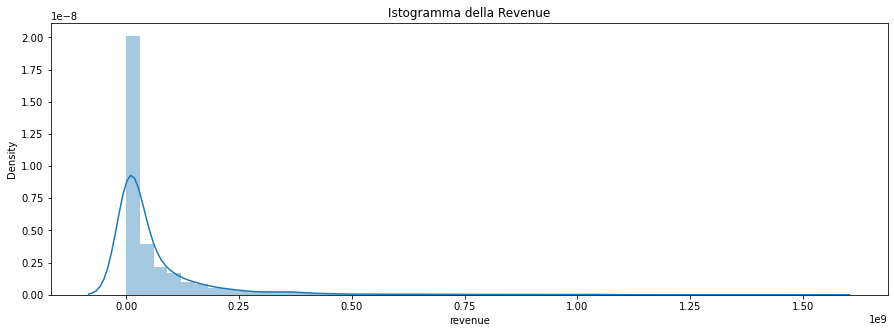

In [58]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(df['revenue']).set_title("Istogramma della Revenue") # generazione del grafico

Si può notare che nessun film ha valore NaN di `revenue`

In [59]:
df['revenue'].isna().sum()

0

Alcuni film, però, hanno `revenue` "basse" (sembrano valori strani per un incasso di un film...)

In [60]:
(df['revenue']<=999).sum()

57

**Esplorando i dati e cercando informazioni sul web**, abbiamo notato che **alcuni film hanno una revenue bassa** in quanto sono scritti in unità diverse (migliaia, milioni...) mentre altri hanno revenue realmente basse. 
Ad esempio, alcuni film con revenue pari a 500 stanno ad indicare 500.000, altri film con revenue ad esempio pari a 200 invece indicano una effettiva revenue di 200!!

C'è un chiaro **problema di unità di misura**, ma analizzando i dati abbiamo notato **più valori bassi che in realtà sarebbero alti**, e solitamente i **valori espressi in al più 3 cifre** sono **considerati in milioni**, per cui i valori **sotto la soglia di 999 abbiamo deciso di moltiplicarli per 1.000.000**. 

Sistemiamo i valori

In [61]:
# Moltiplica per 1 milione tutti i valori di revenue inferiori a 999
df['revenue']=df.revenue.mask(df.revenue<=999, df.revenue*1000000)

In [62]:
# Conta tutti i valori sotto a 999
(df['revenue']<=999).sum()

0

Valutiamo nuovamente il grafico

C:\Users\giuli\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Istogramma della Revenue')

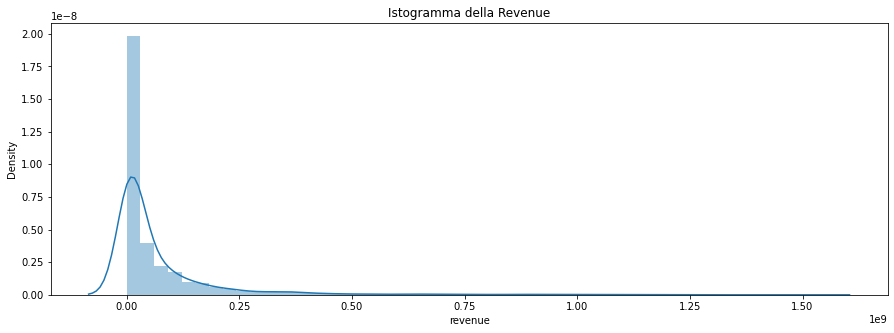

In [63]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(df['revenue']).set_title("Istogramma della Revenue") # generazione del grafico

### Belongs to collection
Nome della collezione a cui il film può appartenenre.

In [64]:
Counter(values_to_list("belongs_to_collection", df)).most_common(15)

[('James Bond Collection', 16),
 ('Friday the 13th Collection', 7),
 ('The Pink Panther (Original) Collection', 6),
 ('Police Academy Collection', 5),
 ('Pokémon Collection', 5),
 ('Rocky Collection', 4),
 ('Ice Age Collection', 4),
 ('The Fast and the Furious Collection', 4),
 ('Rambo Collection', 4),
 ('Alien Collection', 4),
 ('Resident Evil Collection', 4),
 ("Child's Play Collection", 4),
 ('Transformers Collection', 4),
 ('Paranormal Activity Collection', 4),
 ('Rush Hour Collection', 3)]

Vediamo che nessun film ha valore NaN di `belongs_to_collection`

In [65]:
df['belongs_to_collection'].isna().sum()

0

Abbiamo comunque molti film che non appartengono ad alcuna collection

In [66]:
empty_number('belongs_to_collection')

2396

Dato l'elevato numero di empty, riteniamo **più utile** conoscere il **numero di collections**(solitamente una sola) di cui il film fa parte **rispetto** a sapere in **quali collections**: questo per vari motivi, il principale è la difficoltà di gestione dei dati.
Ad esempio, applicando one hot encoding, si verrebbero a creare molte colonne, spesso sparse. 

In [67]:
df['belongs_to_collection'] = df['belongs_to_collection'].apply(len)

### Budget
Budget del film.

C:\Users\giuli\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Istogramma del budget')

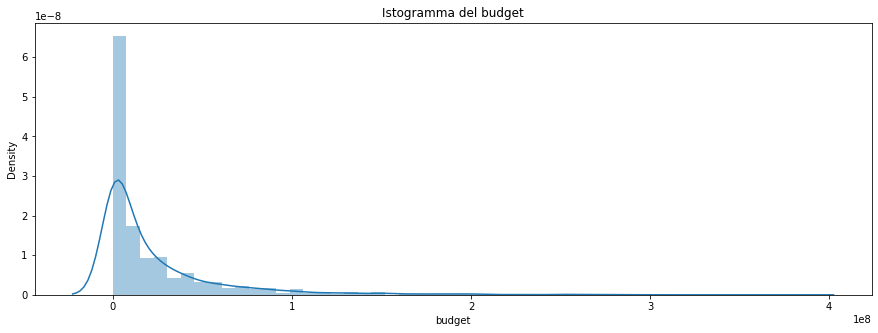

In [68]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(df['budget']).set_title("Istogramma del budget") # generazione del grafico

Vediamo che nessun film ha valore NaN di `budget`

In [69]:
df['budget'].isna().sum()

0

Molti film, però, hanno `budget` bassi, il che ovviamente non è normale.  
Per ovviare al problema, **applicheremo la mediana a tali valori dopo aver splittato il dataframe.**

In [70]:
(df['budget']<=999).sum()

830

La sistemazione dei valori con **l'applicazione dela mediana ai valori che sembrano troppo bassi** verrà eseguita dopo lo splitting in train e test.

### Genres
Generi del film.

In [71]:
Counter(values_to_list("genres", df)).most_common(15)

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100)]

Si può notare una forte popolarità di alcuni generi: **il che è poco significativa**. 
Si potrebbe pensare di mantenere solo i generi meno frequenti, ma ciò porterebbe, eseguendo one hot encoding, ad avere colonne molto sparse: ciò non ci piace. 

Decidiamo quindi di **eliminare la features** in quanto il genere di un film probabilmente non influisce sulla revenue. 

In [72]:
df.drop(labels=['genres'], axis=1, inplace=True)

In [73]:
#df['genres'].isna().sum()
#empty_number('genres')
#df.iloc[find_empty_index('genres')]
#df.loc[470, 'genres'].extend(['Drama', 'Adventure'])                # https://en.wikipedia.org/wiki/The_Book_of_Mormon_Movie
#df.loc[1622,'genres'].extend(['Drama', 'Comedy'])                   # https://en.wikipedia.org/wiki/Jackpot_(2001_film)
#df.loc[1814,'genres'].extend(['Comedy'])                            # https://it.wikipedia.org/wiki/Asja_e_la_gallina_dalle_uova_d'oro
#df.loc[1819,'genres'].extend(['Drama', 'Romance'])                  # https://www.google.com/search?q=Nebo.+Samolyot.+Devushka.&rlz=1C1CHBF_itIT898IT898&oq=Nebo.+Samolyot.+Devushka.&aqs=chrome..69i57j69i61.643j0j4&sourceid=chrome&ie=UTF-8
#df.loc[2423,'genres'].extend(['Action','Drama', 'Romance'])         # https://www.imdb.com/showtimes/title/tt0984177
#df.loc[2686,'genres'].extend(['Mystery', 'Thriller'])               # https://embed.letterboxd.com/film/lift-2006/genres/
#df.loc[2900,'genres'].extend(['Mystery', 'Fantasy'])                # https://it.wikipedia.org/wiki/Poslednjaja_skazka_Rity
#empty_number('genres')

Vediamo che nessun film ha valore NaN di `genres`

Analizziamo **quanti film** sono registrati **senza un genere**.

Dato il **numero ridotto**, possiamo tentare di **sistemare i dati manualmente**. 
Vediamo quali sono i film con genere mancante:

Ora non dovremmo avere più dati mancanti.

### Popularity
Popolarità del film

C:\Users\giuli\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Istogramma della Popularity')

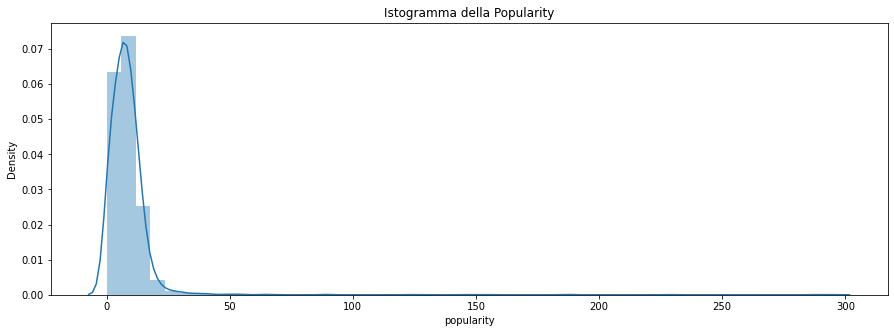

In [74]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(df['popularity']).set_title("Istogramma della Popularity") # generazione del grafico

Vediamo che nessun film ha valore NaN di `popularity`

In [75]:
df['popularity'].isna().sum()

0

Possiamo notare che alcuni valori di **popolarità sono estremamente lontani dagli altri**: è normale?
Analizziamo tali valori e decidiamo cosa fare. 

In [76]:
(df['popularity'] >= 40).sum()

20

In [77]:
df[df['popularity'] >= 40]

,belongs_to_collection,budget,imdb_id,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,keywords,cast,revenue,cast_count,director,crew_count
2,0,3300000,tt2582802,64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],10/10/14,105.0,[English],"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...",13092000,51,[DamienChazelle],64
518,1,149000000,tt0451279,294.337037,"[Dune Entertainment, Atlas Entertainment, Warn...",[United States of America],5/30/17,141.0,"[Deutsch, English]","[dc comics, hero, greek mythology, island, wor...",[],820580447,0,[],0
684,0,160000000,tt2771200,287.253654,"[Walt Disney Pictures, Mandeville Films]","[United Kingdom, United States of America]",3/16/17,129.0,[English],"[france, magic, castle, fairy tale, musical, c...","[Emma Watson, Dan Stevens, Luke Evans, Kevin K...",1262886337,156,[BillCondon],115
934,1,40000000,tt4425200,49.247505,"[Thunder Road Pictures, LionsGate, 87Eleven]",[United States of America],2/8/17,122.0,"[English, Italiano]","[italy, gun, roof, party, sequel, handshake]",[],171539887,0,[],0
1093,1,6000000,tt0068646,41.109264,"[Paramount Pictures, Alfran Productions]",[United States of America],3/14/72,175.0,"[English, Italiano, Latin]","[italy, love at first sight, loss of father, p...","[Marlon Brando, Al Pacino, James Caan, Richard...",245066411,58,[FrancisFordCoppola],42
1126,1,220000000,tt0848228,89.887648,"[Paramount Pictures, Marvel Studios]",[United States of America],4/25/12,143.0,[English],"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",1519557910,115,[JossWhedon],147
1309,0,61000000,tt2267998,154.801009,"[Twentieth Century Fox Film Corporation, Regen...",[United States of America],10/1/14,145.0,[English],"[based on novel, marriage crisis, disappearanc...","[Ben Affleck, Rosamund Pike, Carrie Coon, Neil...",369330363,72,[DavidFincher],82
1643,1,61000000,tt4046784,41.225769,"[Gotham Group, Temple Hill Entertainment, TSG ...",[United States of America],9/9/15,132.0,[English],"[based on novel, resistance, maze, post-apocal...","[Dylan O'Brien, Kaya Scodelario, Thomas Brodie...",311256926,37,[WesBall],99
1673,1,185000000,tt0468569,123.167259,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",7/16/08,152.0,"[English, 普通话]","[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",1004558444,134,[ChristopherNolan],81
1695,0,34000000,tt3890160,228.032744,"[Big Talk Productions, TriStar Pictures, Media...","[United Kingdom, United States of America]",6/28/17,113.0,[English],"[robbery, atlanta, music, crime boss, romance,...","[Ansel Elgort, Lily James, Kevin Spacey, Jamie...",224511319,56,[EdgarWright],183


Notiamo che **molti di questi film** appartengono a **collezioni di grande notorietà**, ad esempio Pirati dei Caraibi, The Avengers, The Maze Runner... quindi riteniamo che una popolarità così elevata è un **segno distintivo e corretto**: ne segue che **non apportiamo modifiche**. 

### Production Companies
Casa produttrice del film.

In [78]:
Counter(values_to_list("production_companies", df)).most_common(15)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40)]

Vediamo che nessun film ha valore NaN di `production_companies`

In [79]:
df['production_companies'].isna().sum()

0

Analizziamo **quanti film** sono registrati **senza casa produttrice**.

In [80]:
empty_number('production_companies')

156

In [81]:
how_many('production_companies', df)

3695

Assolutamente troppe...  
Non potendo applicare one hot encoding (verrebbero troppe colonne sparse), dobbiamo ridurre di molto!

**Idea:** 
- Si mantengono le **most-significative** fra tutti le compagnie, in modo da ottenere una lista delle compagnie più frequenti nel dataframe (che, secondo noi, sono anche le più famose, tranne alcune eccezioni)
- Per ogni film, si mantiene il **numero di compagnie most-common** che hanno prodotto il film

In [82]:
# Rimozion di tutti gli attori con meno di 10 occorrenze
delete_useless_small_value(df, 25, 'production_companies')

In [83]:
how_many('production_companies', df)

25

In [84]:
MOST_IMPORTANT_COMPANIES = list(Counter(values_to_list('production_companies', df))) # queste 25 companies sono le nostre most_common

Per ogni film, andiamo ora a computare il **numero di attori presenti nella lista** `MOST_IMPORTANT_COMPANIES`

In [85]:
counter_most_significative = count_most_significative(df, 'production_companies', MOST_IMPORTANT_COMPANIES)   # ritorna un dataframe
df = pd.concat([df, counter_most_significative], axis = "columns")                  # Si concatena il dataframe con il df
df.drop(labels=['production_companies'], axis=1, inplace=True)                      # Drop della colonna production_companies

### Production Countries
Nazionalità del film.

In [86]:
Counter(values_to_list("production_countries", df)).most_common(15)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23)]

Vediamo che nessun film ha valore NaN di `production_countries`

In [87]:
df['production_countries'].isna().sum()

0

Analizziamo **quanti film** sono registrati **senza nazionalità**.

In [88]:
empty_number('production_countries')

55

Analizziamo il **numero di valori univoci** per la features `production_countries`.

In [89]:
Counter(values_to_list('production_countries', df)).most_common(20)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15)]

Le frequenze di `production_countries` indicano una **forte prevalenza di stati famosi nel mondo del cinema**. 
Sono presenti, poi, ridotte frequenze per **stati più "rari"**, che assumiamo essere un indicatore **più significativo**. 
Riteniamo plausibile che i film prodotti in uno stato "poco presente" nel mondo del cinema possano avere caratteristiche più simili rispetto a molti film prodotti, ad esempio, in america. 

Per cui scartiamo tutte le `production_countries` poco significative, ovvero con una occorrenza maggiore di `50`.

In [90]:
# Rimozione di tutte le production_companies con meno di 50 occorrenze
delete_useless_big_value(df, 50, 'production_countries')

In [91]:
how_many('production_countries', df)

63

**Idea:** 
- Rappresenrtiamo la `production_countries` come codifica binaria: appartiene o meno alla lista delle nazioni più significative

In [92]:
MOST_SIGNIFICANT_COUNTRIES = list(Counter(values_to_list('production_countries', df))) # queste production_countries sono le più significative

**Per ogni film**, andiamo a computare se **appartiene o meno ad una countires significativa.**

In [93]:
binary_value = count_most_significative(df, 'production_countries', MOST_SIGNIFICANT_COUNTRIES)   # ritorna un dataframe
df = pd.concat([df, binary_value], axis = "columns")                 # Si concatena il dataframe con il df
df.drop(labels=['production_countries'], axis=1, inplace=True)       # Drop della colonna production_countries

### Release Date
Data di uscita del film.  
La data, nel dataframe, è in formato stringa: poco utile.  
Vogliamo **trasformarla in più colonne** indicanti l'anno, il mese, il giorno della settimana e la settimana nell'anno. 

Vediamo che nessun film ha valore NaN di `release_date`

In [94]:
df['release_date'].isna().sum()

0

In [95]:
# Coversione della data da tipo stringa a tipo data
df["release_date"] = pd.to_datetime(df["release_date"], errors = "coerce", infer_datetime_format=True)

In [96]:
# Splitting della data in Anno, Mese, N° settimana e Giorno della settimana.
df["year_release"] = df["release_date"].dt.year
df["month_release"] = df["release_date"].dt.month
df["week_of_year_release"] = df["release_date"].dt.weekofyear
df["day_of_week_release"] = df["release_date"].dt.weekday

<ipython-input-96-2adf8cabcddb>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week_of_year_release"] = df["release_date"].dt.weekofyear


In [97]:
# Rimozione della features modificata
df.drop(labels=["release_date"], axis='columns', inplace=True)

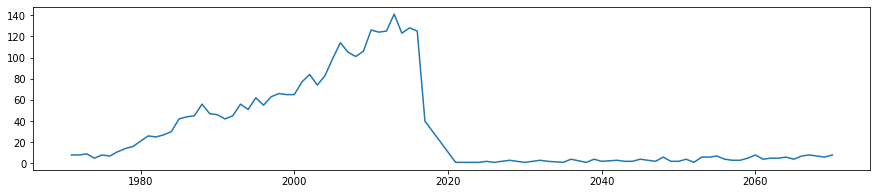

In [98]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(df.groupby("year_release").size())

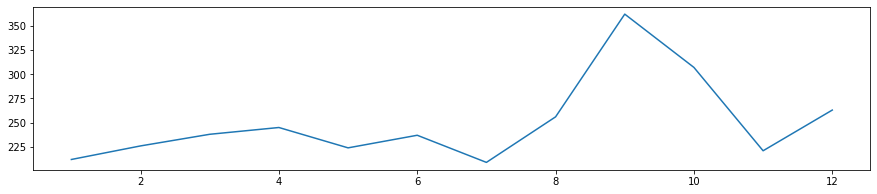

In [99]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(df.groupby("month_release").size())

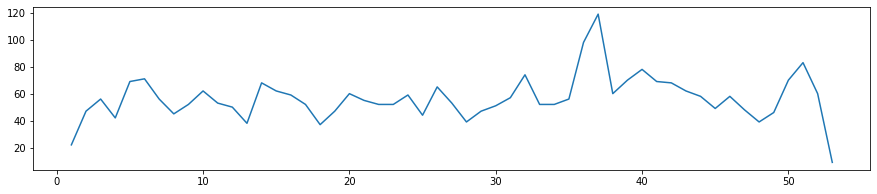

In [100]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(df.groupby("week_of_year_release").size())

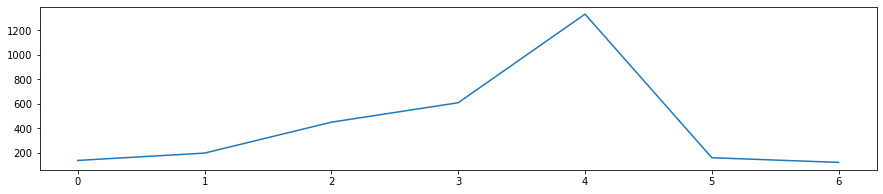

In [101]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(df.groupby("day_of_week_release").size())

Possiamo notare dal **grafico dell'anno** che nel dataframe sono presenti film con **anno di rilascio superiore all'anno attuale**: **vengono dal futuro?** Proviamo a scoprirlo.   

Visualizziamo i film con data superiore alla data di rilascio del database. 

In [102]:
(df['year_release'] >= 2018).sum()

160

In [103]:
df[df['year_release'] >= 2018]

,belongs_to_collection,budget,imdb_id,popularity,runtime,spoken_languages,keywords,cast,revenue,cast_count,director,crew_count,production_companies_most_significative,production_countries_most_significative,year_release,month_release,week_of_year_release,day_of_week_release
39,0,3800000,tt0059418,3.055936,123.0,"[English, Français, Español]","[mexico, prisoners of war, apache, raid, confe...","[Charlton Heston, Richard Harris, Jim Hutton, ...",14873,14,[SamPeckinpah],12,1,0,2065,4,15,1
41,0,3000000,tt0061512,9.718713,126.0,[English],"[prison, rebel, loss of mother, harassment, im...","[Paul Newman, George Kennedy, Luke Askew, Morg...",16217773,32,[StuartRosenberg],28,1,0,2067,6,25,2
51,0,12000000,tt0059243,4.473327,160.0,"[English, Italiano]","[slapstick, ensemble cast, automobile racing, ...","[Jack Lemmon, Tony Curtis, Natalie Wood, Peter...",25333333,17,[BlakeEdwards],6,1,0,2065,7,27,2
61,0,4000000,tt0049875,1.801071,105.0,"[English, Italiano]","[circus, trapeze artist]","[Burt Lancaster, Tony Curtis, Gina Lollobrigid...",14400000,15,[CarolReed],9,0,0,2056,5,22,1
68,0,2000000,tt0056592,14.284787,129.0,[English],"[black people, based on novel, brother sister ...","[Gregory Peck, Brock Peters, James Anderson, M...",13129846,56,[RobertMulligan],34,1,0,2062,12,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,0,12000000,tt0060934,11.354247,182.0,"[English, 普通话]","[missionary, china, u.s. navy, chinese, battle...","[Steve McQueen, Richard Attenborough, Richard ...",20000000,30,[RobertWise],13,1,0,2066,12,51,0
2945,0,1000000,tt0057590,3.315827,128.0,[English],"[from rags to riches, tutor, squire]","[Albert Finney, Susannah York, Hugh Griffith, ...",37600000,18,[TonyRichardson],7,0,0,2063,10,40,5
2946,0,483103,tt0018183,0.205671,80.0,[English],[],"[Mary Pickford, Charles 'Buddy' Rogers, Sunshi...",1027757,23,[SamTaylor],10,0,0,2027,10,43,6
2967,1,2000000,tt0054997,9.333533,134.0,[English],"[suicide, gambling, manager, alcohol, based on...","[Paul Newman, Jackie Gleason, Piper Laurie, Ge...",7600000,15,[RobertRossen],14,1,0,2061,9,38,6


Cercando gli `imdb_id` di un numero sufficiente di film, si può notare che le date sono **riferite al 1900** e non al 2000.  
Ad esempio, il primo film con `imdb_id = tt0059418` è stato rilasciato nel 1965 e non nel 2065. (https://www.imdb.com/title/tt0059418/)  

Non potendo controllare tutti i film manualmente, assumiamo che tutti i film con data superiore al 2018 sono in realtà riferiti a 100 anni prima, per cui **modifichiamo tali dati sottraendo 100 anni**. 

In [104]:
df['year_release'] = df.year_release.mask(df.year_release >= 2018, df.year_release-100)

In [105]:
(df['year_release'] >= 2018).sum()

0

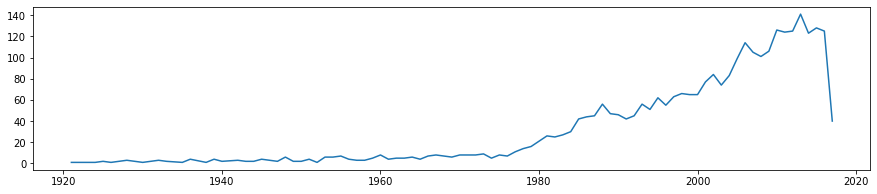

In [106]:
plt.figure(figsize=(15,3)) # Grandezza del grafico
plt.plot(df.groupby("year_release").size())

### Runtime
Durata del film.

C:\Users\giuli\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Istogramma del Runtime')

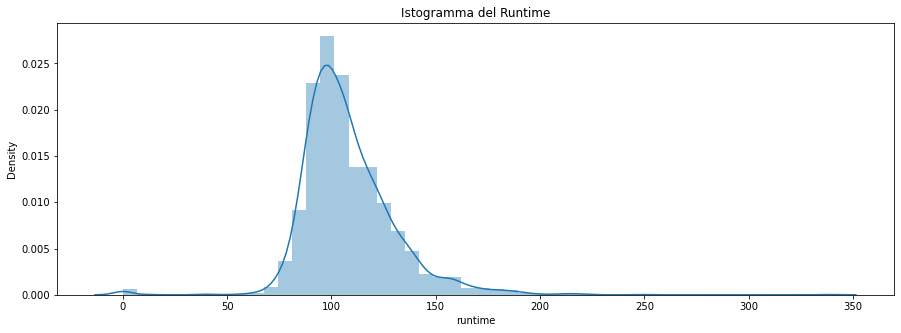

In [107]:
plt.figure(figsize=(15,5)) # Grandezza del grafico
sns.distplot(df['runtime']).set_title("Istogramma del Runtime") # generazione del grafico

Vediamo che due film hanno **valore NaN di** `runtime`

In [108]:
df['runtime'].isna().sum()

2

Quali sono questi due film?

In [109]:
df[df['runtime'].isna()]

,belongs_to_collection,budget,imdb_id,popularity,runtime,spoken_languages,keywords,cast,revenue,cast_count,director,crew_count,production_companies_most_significative,production_countries_most_significative,year_release,month_release,week_of_year_release,day_of_week_release
1335,0,6000000,tt1107828,0.292296,NaN,[],[],[Sergei Astahov],31000,1,[YuriyKara],2,0,0,2007,10,44,0
2302,0,0,tt0116485,0.002229,NaN,[Deutsch],"[sex, adultery, group sex, bisexuality]","[Erik Goertz, Anton Rattinger, Dieter Wardetzk...",65335,7,[],0,0,0,1996,3,11,3


Inseriamo i valori **corretti manualmente**

In [110]:
df.loc[1335,'runtime'] = 130         # https://www.imdb.com/title/tt1107828/
df.loc[2302,'runtime'] = 90          # https://trakt.tv/movies/happy-weekend-1996

Molti film, inoltre, hanno `runtime` pari a 0, il che ovviamente non ha senso.

In [111]:
(df['runtime']==0).sum()

12

La sistemazione dei valori **sostituendo gli 0 con la mediana** verrà fatta successivamente lo spitting in train e test. 

### Spoken languages
Lingue in cui il film è stato tradotto.

In [112]:
Counter(values_to_list("spoken_languages", df)).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

Vediamo che nessun film ha valore NaN di `spoken_languages`

In [113]:
df['spoken_languages'].isna().sum()

0

Analizziamo **quanti film** sono registrati **senza lingue di traduzione**.

In [114]:
empty_number('spoken_languages')

20

Analizziamo il **numero di valori univoci** per la features `spoken_languages`.

In [115]:
how_many('spoken_languages', df)

56

Il numero non è eccessivo, ma riteniamo **più utile** conoscere il **numero di lingue** in cui il film è tradotto **rispetto** a sapere in **quali lingue**.

In [116]:
df['spoken_languages'] = df['spoken_languages'].apply(len)

### Keywords
Parole chiave per il film.

In [117]:
Counter(values_to_list("keywords", df)).most_common(15)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66)]

Vediamo che nessun film ha valore NaN di `keywords`

In [118]:
df['keywords'].isna().sum()

0

Analizziamo **quanti film** sono registrati **senza keywords**.

In [119]:
empty_number('keywords')

276

### Cast
Attori dei film

Analizziamo il **numero di valori univoci** per la features `cast`.

In [120]:
how_many('cast', df)

7718

Assolutamente troppi... dobbiamo ridurre di molto!

**Idea:** 
- Di ogni film abbiamo già tenuto solo i primi 5 (i più importanti, come già analizzato in precedenza)
- Si mantengono i **most-significative** fra tutti gli attori selezionati, in modo da ottenere una lista degli attori più frequenti nel dataframe (che, secondo noi, sono anche i più famosi, tranne alcune eccezioni)
- Per ogni film, si mantiene il **numero di attori most-common** che hanno recitato in quel film

In [121]:
df['cast'][1126]

['Robert Downey Jr.',
 'Chris Evans',
 'Mark Ruffalo',
 'Chris Hemsworth',
 'Scarlett Johansson']

In [122]:
# Rimozion di tutti gli attori con meno di 10 occorrenze
delete_useless_small_value(df, 10, 'cast')

In [123]:
df['cast'][1126]

['Robert Downey Jr.', 'Mark Ruffalo', 'Scarlett Johansson']

In [124]:
how_many('cast', df)

147

In [125]:
MOST_IMPORTANT_ACTORS = list(Counter(values_to_list('cast', df))) # questi 147 attori sono i nostri most_common

Per ogni film, andiamo ora a computare il **numero di attori presenti nella lista** `MOST_IMPORTANT_ACTORS`

In [126]:
counter_most_significative = count_most_significative(df, 'cast', MOST_IMPORTANT_ACTORS)   # ritorna un dataframe
df = pd.concat([df, counter_most_significative], axis = "columns")                  # Si concatena il dataframe con il train
df.drop(labels=['cast'], axis=1, inplace=True)                                      # Drop della colonna cast

### Director
Registi dei film

Analizziamo il **numero di valori univoci** per la features `director`.

In [127]:
how_many('director', df)

1858

In [128]:
#Counter(values_to_list('director', df)).most_common()

Si può notare che molti registi hanno diretto un solo film: non è significativo, possiamo rimuoverli. 

In [129]:
delete_useless_small_value(df, 2, 'director')

In [130]:
how_many('director', df)

576

Come per gli attori, vogliamo creare una lista di `most_common_director` e tenere, per ogni film, una variabile binaria indicante se il `director` del film è tra quelli più importanti oppure no. 
**Idea:** 
- Di ogni film abbiamo già tenuto il regista
- Si mantengono i **most-common** fra tutti i registi selezionati, in modo da ottenere una lista dei registi più frequenti nel dataframe (che, secondo noi, sono anche i più famosi, tranne alcune eccezioni)
- Per ogni film, si mantiene il **il valore binario has-common-director** che indica se il regista è tra quelli importanti.


Assumiamo che i registi con **almeno 5 film** siano i registi più significativi. 

In [131]:
delete_useless_small_value(df, 5, 'director')

In [132]:
how_many('director', df)

77

In [133]:
MOST_IMPORTANT_DIRECTORS = list(Counter(values_to_list('director', df)))

In [134]:
counter_most_significative = count_most_significative(df, 'director', MOST_IMPORTANT_DIRECTORS) # ritorna un dataframe
df = pd.concat([df, counter_most_significative], axis = "columns")               # Si concatena il dataframe con il train
df.drop(labels=['director'], axis=1, inplace=True)                                  # Drop della colonna director

### Valutazione finale
Ora dovremmo avere un **dataset facile da esplorare** e **non** dovrebbero più **esserci** al suo interno **valori mancani o valori anomali**. 
Ovviamente, le operazioni svolte non sono state le più precise, ma svolgere tutte i controlli e le sistemazioni a mano sarebbe risultato troppo complesso. 

In [135]:
df.describe(include='all')

,belongs_to_collection,budget,imdb_id,popularity,runtime,spoken_languages,keywords,revenue,cast_count,crew_count,production_companies_most_significative,production_countries_most_significative,year_release,month_release,week_of_year_release,day_of_week_release,cast_most_significative,director_most_significative
count,3000.000000,3.000000e+03,3000,3000.000000,3000.000000,3000.000000,3000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0000,3000.000000
unique,NaN,NaN,3000,NaN,NaN,NaN,2649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,tt2725962,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,NaN,NaN,NaN,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.201333,2.253133e+07,NaN,8.463274,107.858000,1.452333,NaN,6.904852e+07,20.603667,24.365667,0.550000,0.143000,1999.713000,6.775333,27.818000,3.253333,0.6450,0.155333
std,0.401063,3.702609e+07,NaN,12.104000,22.085178,0.887688,NaN,1.400506e+08,16.629635,28.066419,0.638986,0.440396,15.423313,3.409115,14.844471,1.330568,0.9088,0.362283
min,0.000000,0.000000e+00,NaN,0.000001,0.000000,0.000000,NaN,1.404000e+03,0.000000,0.000000,0.000000,0.000000,1921.000000,1.000000,1.000000,0.000000,0.0000,0.000000
25%,0.000000,0.000000e+00,NaN,4.018053,94.000000,1.000000,NaN,2.850197e+06,11.000000,8.000000,0.000000,0.000000,1993.000000,4.000000,15.000000,2.000000,0.0000,0.000000
50%,0.000000,8.000000e+06,NaN,7.374861,104.000000,1.000000,NaN,1.764559e+07,16.000000,14.000000,0.000000,0.000000,2004.000000,7.000000,29.000000,4.000000,0.0000,0.000000
75%,0.000000,2.900000e+07,NaN,10.890983,118.000000,2.000000,NaN,7.227168e+07,24.000000,28.000000,1.000000,0.000000,2011.000000,10.000000,40.000000,4.000000,1.0000,0.000000


In [136]:
df.columns

Index(['belongs_to_collection', 'budget', 'imdb_id', 'popularity', 'runtime',
       'spoken_languages', 'keywords', 'revenue', 'cast_count', 'crew_count',
       'production_companies_most_significative',
       'production_countries_most_significative', 'year_release',
       'month_release', 'week_of_year_release', 'day_of_week_release',
       'cast_most_significative', 'director_most_significative'],
      dtype='object')

## Split in Train e Test
Arrati a questo punto, **splitiamo il dataframe in train e test.**

In [137]:
X = df.drop("revenue", axis='columns', inplace = False)    # Teniamo solo le X
y = df["revenue"]                                          # Si tengono solo le y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  # Splittiamo in train e test

In [138]:
# Split in train e test
X_train.reset_index(drop=True, inplace=True)   # X del train
X_test.reset_index(drop=True, inplace=True)    # X del test
y_train.reset_index(drop=True, inplace=True)   # y del train
y_test.reset_index(drop=True, inplace=True)    # y del test
#

## Analisi delle Features e sistemazione dei valori dopo lo splitting

### Budget
Sistemiamo i valori di `budget` bassi sia nel train che nel test. 

In [139]:
apply_median(X_train, 'budget', '<=', 999)
apply_median(X_test , 'budget', '<=', 999)

<ipython-input-12-a02075982a7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column]=dataframe[column].mask(dataframe[column]<=value, median)   # sostituzione dei valori sotto la soglia
<ipython-input-12-a02075982a7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column]=dataframe[column].mask(dataframe[column]<=value, median)   # sostituzione dei valori sotto la soglia


### Runtime
Sistemiamo i valori di `runtime` bassi sia nel train che nel test. 

In [140]:
apply_median(X_train, 'runtime', '==', 0)
apply_median(X_test , 'runtime', '==', 0)

<ipython-input-12-a02075982a7c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column]=dataframe[column].mask(dataframe[column]==value, median)   # sostituzione dei valori sotto la soglia
<ipython-input-12-a02075982a7c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column]=dataframe[column].mask(dataframe[column]==value, median)   # sostituzione dei valori sotto la soglia


## Preparazione al One Hot Encoding
Attualmente **l'unica colonna non numerica** è `keywords`: risulta essere un problema per l'esecuzione degli algoritmi di predizione.  
Un modo per risolvere tale problema è eseguire **One Hot Encoding**, ma, il risultato finale sarebbe di troppe colonne: dobbiamo capire come gestirle.

### Keywords

Analizziamo il **numero di valori univoci** per la features `keywords`.

In [141]:
(how_many('keywords', X_train), how_many('keywords', X_test))

(5821, 3744)

Dato l'elevato numero di `keywords`, siamo costretti a trovare un modo per **ridurle**.  
Il metodo che abbiamo scelto di applicare consiste nel **tenere solamente le keyword più significative**, ovvero le keyword meno frequenti. 

In [142]:
delete_useless_big_value(X_train, 30, 'keywords')
delete_useless_small_value(X_train, 2, 'keywords')

delete_useless_big_value(X_test, 30, 'keywords')
delete_useless_small_value(X_test, 2, 'keywords')

(how_many('keywords', X_train), how_many('keywords', X_test))

(2257, 1215)

Bene, abbiamo abbassato il valore... ma non è ancora sufficientemente basso per applicare One Hot Encoding. 
Riduciamo ancora....

In [143]:
delete_useless_big_value(X_train, 15, 'keywords')
delete_useless_big_value(X_test , 15, 'keywords')

(how_many('keywords', X_train), how_many('keywords', X_test))

(2187, 1194)

Ancora troppe...

In [144]:
delete_useless_big_value(X_train, 2, 'keywords')
delete_useless_big_value(X_test , 2, 'keywords')

(how_many('keywords', X_train), how_many('keywords', X_test))

(1001, 614)

Sono troppe, ma non possiamo ridurre ancora, **siamo arrivati al limite**... 
Siamo quindi obbligati a scartare la feature keywords. 

Un'alternativa sarebbe mantenenre le most_common, ma più una keyword è frequente e meno significativa è, per cui non ha senso. 

Si potrebbe provare un miglioramento raccogliendo le keywords in gruppi per semantica, ma è un compito troppo dispendioso. 

In [145]:
X_train.drop(labels=['keywords'], axis='columns', inplace=True)
X_test.drop(labels=['keywords'], axis='columns', inplace=True)

C:\Users\giuli\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Valutazione dataframe dopo le modifiche

In [146]:
# drop della features imdb_id
X_train.drop(['imdb_id'], axis='columns', inplace=True)
X_test.drop(['imdb_id'], axis='columns', inplace=True)

In [147]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   belongs_to_collection                    2010 non-null   int64  
 1   budget                                   2010 non-null   float64
 2   popularity                               2010 non-null   float64
 3   runtime                                  2010 non-null   float64
 4   spoken_languages                         2010 non-null   int64  
 5   cast_count                               2010 non-null   int64  
 6   crew_count                               2010 non-null   int32  
 7   production_companies_most_significative  2010 non-null   int64  
 8   production_countries_most_significative  2010 non-null   int64  
 9   year_release                             2010 non-null   int64  
 10  month_release                            2010 no

In [148]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   belongs_to_collection                    990 non-null    int64  
 1   budget                                   990 non-null    float64
 2   popularity                               990 non-null    float64
 3   runtime                                  990 non-null    float64
 4   spoken_languages                         990 non-null    int64  
 5   cast_count                               990 non-null    int64  
 6   crew_count                               990 non-null    int32  
 7   production_companies_most_significative  990 non-null    int64  
 8   production_countries_most_significative  990 non-null    int64  
 9   year_release                             990 non-null    int64  
 10  month_release                            990 non-n

In [149]:
#X_train.drop(labels=['popularity', 'runtime', 'spoken_languages', 'cast_count', 'crew_count','production_countries_most_significative','year_release', 'month_release', 'week_of_year_release','day_of_week_release','cast_most_significative', 'director_most_significative'], axis=1, inplace=True)
#X_test.drop(labels=['popularity', 'runtime', 'spoken_languages', 'cast_count', 'crew_count','production_countries_most_significative','year_release', 'month_release', 'week_of_year_release','day_of_week_release','cast_most_significative', 'director_most_significative'], axis=1, inplace=True)

## Esecuzione primo algoritmo
Siamo finalmente pronti per provare un primo algoritmo!

In [150]:
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [151]:
train_acc = np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=model.predict(X_train)))
test_acc  = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=model.predict(X_test)))

In [152]:
[train_acc, test_acc]

[0.0, 2.4422413682731254]

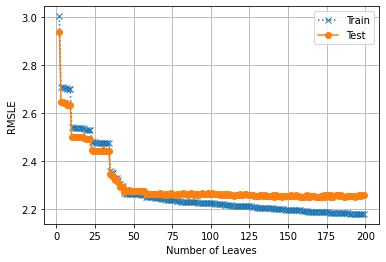

In [153]:
errors = []

for max_leaves in range(2,200):
    # train and predict
    model = tree.DecisionTreeRegressor(max_leaf_nodes=max_leaves) #usiamo l'albero di regressione
    model.fit(X_train,y_train)

    # compute Accuracy
    train_acc =  np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=model.predict(X_train)))
    test_acc =   np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=model.predict(X_test)))

    errors += [ [max_leaves, train_acc, test_acc] ]

errors = np.array(errors)

fig, ax = plt.subplots()
ax.plot(errors[:,0], errors[:,1], "x:", label="Train")
ax.plot(errors[:,0], errors[:,2], "o-", label="Test")
ax.set_ylabel("RMSLE")
ax.set_xlabel("Number of Leaves")
ax.grid()
ax.legend()

Notiamo che si può fare **fine-tuning sul numero delle foglie** in quanto all'aumentare del numero di foglie l' RMSLE diminuisce...

### Prime conclusioni
Al momento abbiamo runnato un primo algoritmo basato sugli alberi. Con gli alberi sappiamo di poter fare fine tuning ottenendo risultati differenti a seconda del numero di foglie che specifichiamo, questo infatti si può vedere dal grafico qui sopra. 
Notiamo che all'aumentare del numero di foglie il RMSLE diminuisce, ma, sul test, va ad appiattirsi dopo una certa soglia. Quindi che numero di foglie scegliamo?
Questa decisione non può essere presa sul dataset di test. Effettuiamo quindi un ulteriore splitting questa volta in train, validation e test.

## Fine tuning dei parametri
Passiamo quindi alla fase di fine tuning dei parametri, per farlo splittiamo il dataset utilizzando k-fold cross validation, per ottenere una separazione più imparziale.
Rieseguiamo lo splitting in train e test cambiando le percentuali di splitting, in modo da avere un 60/20/20 quando inseriremo il validation. 

In [164]:
X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size=0.20, random_state=42) #splittiamo in train e test

IndexingError: Too many indexers

In [155]:
X_train_80.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 642 to 860
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   belongs_to_collection                    2400 non-null   int64  
 1   budget                                   2400 non-null   int64  
 2   imdb_id                                  2400 non-null   object 
 3   popularity                               2400 non-null   float64
 4   runtime                                  2400 non-null   float64
 5   spoken_languages                         2400 non-null   int64  
 6   keywords                                 2400 non-null   object 
 7   cast_count                               2400 non-null   int64  
 8   crew_count                               2400 non-null   int32  
 9   production_companies_most_significative  2400 non-null   int64  
 10  production_countries_most_significative  2400 n

Resettiamo nuovamente gli indici

In [156]:
X_train_80.reset_index(drop=True, inplace=True)   # X del train
X_test.reset_index(drop=True, inplace=True)    # X del test
y_train_80.reset_index(drop=True, inplace=True)   # y del train
y_test.reset_index(drop=True, inplace=True)    # y del test

In [158]:
X_train_80.drop(labels=['imdb_id', 'keywords'], axis='columns', inplace=True)
X_test.drop(labels=['imdb_id', 'keywords'], axis='columns', inplace=True)

C:\Users\giuli\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Risistemiamo budget e runtime come fatto in precedenza

In [159]:
apply_median(X_train_80, 'budget', '<=', 999)
apply_median(X_test , 'budget', '<=', 999)
apply_median(X_train_80, 'runtime', '==', 0)
apply_median(X_test , 'runtime', '==', 0)

<ipython-input-12-a02075982a7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column]=dataframe[column].mask(dataframe[column]<=value, median)   # sostituzione dei valori sotto la soglia
<ipython-input-12-a02075982a7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column]=dataframe[column].mask(dataframe[column]<=value, median)   # sostituzione dei valori sotto la soglia
<ipython-input-12-a02075982a7c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

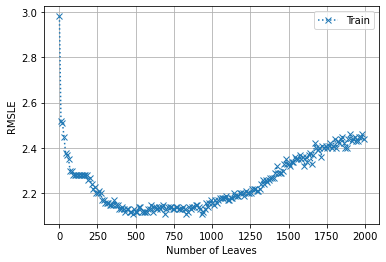

In [203]:
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import LeaveOneOut

def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

RMSLE = make_scorer(rmsle_score)
accuracies = []

for max_leaves in range(2,2000, 10):
    # train and predict
    dt = tree.DecisionTreeRegressor(max_leaf_nodes=max_leaves)
    #dt.fit(X_train,y_train)
    scores = cross_val_score(dt, X_train_80, y_train_80, scoring=RMSLE, cv=5)
    valid_RMSLE = round(np.mean(scores), 2)
    #print ("Leaves: {:2d} - Validation RMSLE: {}".format(max_leaves,  valid_RMSLE))
    
    accuracies += [ [valid_RMSLE, max_leaves ] ]

best_accuracy, best_max_leaves = min(accuracies)
#print ( "Best Max Leaves", best_max_leaves )
errors = np.array(accuracies)

fig, ax = plt.subplots()
ax.plot(errors[:,1], errors[:,0], "x:", label="Train")
ax.set_ylabel("RMSLE")
ax.set_xlabel("Number of Leaves")
ax.grid()
ax.legend()

In [204]:
min(accuracies)

[2.11, 482]